# Visualising IR Spectra from SAKE Experiments

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime

### Function for Plotting IR Spectra

In [2]:
def parse_time_str(t_str):
    """
    Parses a time string in HH:MM:SS format into a datetime object.
    Useful for time comparisons and sorting.
    """
    return datetime.strptime(t_str, '%H:%M:%S')

def plot_ir_spectra(xlsx_file, stop_at=1000, selected=None, x_limits=None, y_limits=None, 
                    y_shifter=0, figsize=None, legend=True, legend_outside=False, 
                    time_label='Default', experiment_start=0, save_svg=False, sheet=None,
                    legend_limit=None, vertical_lines=None, vline_width=1,
                    n_spectra=None, experiment_name=None):
    """
    Plot in-situ IR spectra from an Excel file where the first column is wavenumbers
    and subsequent columns are spectra collected at different time points.

    Parameters:
    - xlsx_file (str): Path to the Excel file containing IR data.
    - stop_at (int): Maximum number of spectra (columns) to plot.
    - selected (list): Optional substrings to filter which spectra/timepoints to include.
    - x_limits (tuple): (min, max) limits for x-axis (wavenumber).
    - y_limits (tuple or str): Limits for y-axis or percentage padding (e.g., '10%').
    - y_shifter (float): Vertical offset applied incrementally to each spectrum for clarity.
    - figsize (tuple): Figure size (width, height).
    - legend (bool): Whether to show the legend.
    - legend_outside (bool): Place legend outside the plot area.
    - time_label (str): Format for time labels in legend ('Default', 'min', 'h').
    - experiment_start (int/list): Numeric or list of start and reaction times to calculate relative time.
    - save_svg (bool): Save the plot as an SVG file if True.
    - sheet (str): Sheet name to read from Excel file.
    - legend_limit (int): Max legend entries per row when legend is outside.
    - vertical_lines (list of lists): Two lists of x-positions for dashed and solid vertical lines.
    - vline_width (float): Width of vertical lines.
    - n_spectra (int): Number of spectra to evenly sample and plot.
    - experiment_name (str): Title of the experiment for the plot.

    Returns:
    - None (displays the plot)
    """

    # Read Excel data, selecting specific sheet if provided
    df = pd.read_excel(xlsx_file, sheet_name=sheet) if sheet else pd.read_excel(xlsx_file)

    # Extract wavenumbers (first column)
    wavenumbers = df.iloc[:, 0].values

    # Extract time tags (column headers after the first column)
    time_tags = df.columns[1:]

    # Filter time tags if 'selected' substrings are provided
    if selected:
        time_tags = [tag for tag in time_tags if any(s in tag for s in selected)]

    # Limit number of spectra if stop_at is specified
    if stop_at:
        time_tags = time_tags[:stop_at]

    # Parse experiment start time if given as list of strings
    if isinstance(experiment_start, list) and len(experiment_start) == 2:
        try:
            start_time = parse_time_str(experiment_start[0])
            reaction_time = parse_time_str(experiment_start[1])
            delta = (reaction_time - start_time).total_seconds()
            if time_label == 'min':
                experiment_start = delta / 60
            elif time_label == 'h':
                experiment_start = delta / 3600
            else:
                experiment_start = 0
        except Exception as e:
            print(f"Failed to parse experiment_start: {e}")
            experiment_start = 0

    # Parse time information from the tags (extract total seconds from HH:MM:SS format)
    time_info = []
    for tag in time_tags:
        match = re.search(r'(\d{1,2}):(\d{2}):(\d{2})', str(tag))
        if match:
            h, m, s = map(int, match.groups())
            total_seconds = h * 3600 + m * 60 + s
            time_info.append((tag, total_seconds))
        else:
            time_info.append((tag, float('inf')))  # Put unparseable tags at the end

    # Sort tags by their parsed time value
    time_info.sort(key=lambda x: x[1])

    # If requested, evenly sample a subset of spectra
    if n_spectra and n_spectra < len(time_info):
        indices = np.linspace(0, len(time_info) - 1, n_spectra).astype(int)
        time_info = [time_info[i] for i in indices]

    # Unpack sorted (and possibly sampled) time tags
    time_tags = [tag for tag, _ in time_info]

    # Start plotting figure with specified or default size
    plt.figure(figsize=figsize if figsize else [7, 5])

    # Plot each spectrum with vertical shifting for clarity
    for i, tag in enumerate(time_tags):
        intensity = df[tag].values
        shifted = intensity + i * y_shifter
        label = tag

        # If time_label is 'min' or 'h', convert and adjust label accordingly
        if time_label in ['min', 'h']:
            match = re.search(r'(\d{1,2}):(\d{2}):(\d{2})', str(tag))
            if match:
                h, m, s = map(int, match.groups())
                total_seconds = h * 3600 + m * 60 + s
                value = total_seconds / (60 if time_label == 'min' else 3600) - experiment_start
                if time_label == 'h':
                    label = f"{value:.2f} {time_label}"
                else:
                    label = f"{value:.1f} {time_label}"

        plt.plot(wavenumbers, shifted, label=label)

        # Handle x-axis limits and masking for y-limit calculations
        if x_limits:
            plt.xlim(x_limits[0], x_limits[1])
            x_min, x_max = x_limits
            x_mask = (wavenumbers >= x_min) & (wavenumbers <= x_max)
        else:
            x_mask = np.ones_like(wavenumbers, dtype=bool)

    # Calculate y-limits if specified as percentage string
    if isinstance(y_limits, str) and y_limits.endswith('%'):
        try:
            percent = float(y_limits.strip('%')) / 100
            all_shifted = [
                (df[tag].values[x_mask] + i * y_shifter)
                for i, tag in enumerate(time_tags)
            ]
            combined = np.concatenate(all_shifted)
            ymin, ymax = np.min(combined), np.max(combined)
            y_padding = (ymax - ymin) * percent
            #print('ylim', ymin - y_padding, ymax + y_padding)
            plt.ylim(ymin - y_padding, ymax + y_padding)
        except Exception as e:
            print(f"Failed to compute y-limits from percentage: {e}")
    elif y_limits:
        plt.ylim(y_limits[0], y_limits[1])

    # Invert x-axis (wavenumber decreasing left to right)
    plt.gca().invert_xaxis()

    # Axis labels
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Absorbance')

    # Title
    if experiment_name is not None:
        plt.title(f'In-situ IR spectra for {experiment_name}')
    else:
        plt.title('In-situ IR spectra.')

    # Plot vertical lines if provided (dashed and solid)
    if vertical_lines:
        dashed_lines = vertical_lines[0] if len(vertical_lines) > 0 else []
        solid_lines = vertical_lines[1] if len(vertical_lines) > 1 else []

        for x in dashed_lines:
            plt.axvline(x=x, color='gray', linestyle='--', linewidth=vline_width)
        for x in solid_lines:
            plt.axvline(x=x, color='black', linestyle='-', linewidth=vline_width)

    # Legend display and placement
    if legend:
        handles, labels = plt.gca().get_legend_handles_labels()
        if legend_outside:
            if legend_limit and len(labels) > legend_limit:
                ncol = int(np.ceil(len(labels) / legend_limit))
                plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), ncol=ncol)
            else:
                plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
            plt.tight_layout()
        else:
            if legend_limit and len(labels) > legend_limit:
                ncol = int(np.ceil(len(labels) / legend_limit))
                plt.legend(ncol=ncol)
            else:
                plt.legend()

    # Save plot as SVG if requested
    if save_svg:
        out_path = os.path.splitext(xlsx_file)[0] + "_IR_spectra.svg"
        if sheet is not None:
            out_path = os.path.splitext(xlsx_file)[0] + sheet + "_IR_spectra.svg"
        if experiment_name is not None:
            out_path = os.path.splitext(xlsx_file)[0] + experiment_name + "_IR_spectra.svg"
        plt.savefig(out_path, format='svg', bbox_inches='tight')

    # Show the plot
    plt.show()

### Upload the IR Spectra as a Dataframe

In [3]:
IR_spectra_examples=pd.read_excel('ESI_SAKE_IR_spectra.xlsx',sheet_name=None)

### Plotting IR spectra for Appendix of SAKE Publication

__C1_E4a__

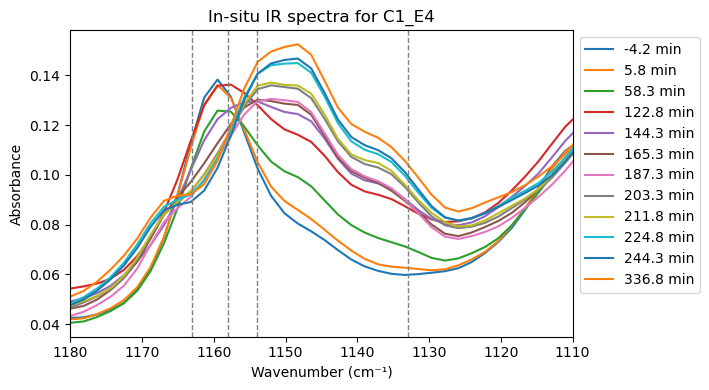

In [4]:
plot_ir_spectra(
    'ESI_SAKE_IR_spectra.xlsx', 
    stop_at=None, 
    selected=None, 
    x_limits=[1110, 1180], 
    y_limits='5%' ,
    y_shifter=0, 
    figsize=(7.2, 4), 
    legend=True, 
    save_svg=True,
    legend_outside=True,
    time_label='min',
    experiment_start=['13:38:51','13:43:28'],
    legend_limit=16,
    sheet='C1_E4',
    vertical_lines=[[1163,1158,1154,1133],[]],
    n_spectra=12,
    experiment_name='C1_E4'
)


__C2_E4__

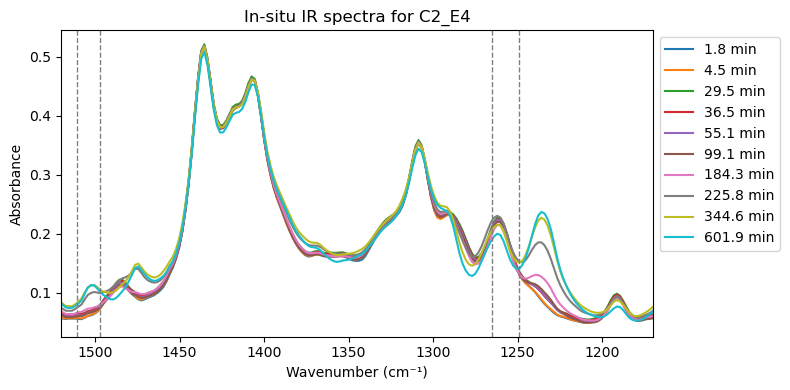

In [5]:
plot_ir_spectra(
    'ESI_SAKE_IR_spectra.xlsx', 
    stop_at=None, 
    selected=None, 
    x_limits=[1170, 1520], 
    y_limits='5%' ,
    y_shifter=0, 
    figsize=(8, 4), 
    legend=True, 
    save_svg=True,
    legend_outside=True,
    time_label='min',
    experiment_start=['08:08:46','08:25:24'],
    legend_limit=10,
    sheet='C2_E4',
    vertical_lines=[[1265,1249,1511,1497],[]],
    n_spectra=10,
    experiment_name='C2_E4'
)


__C2_E5__

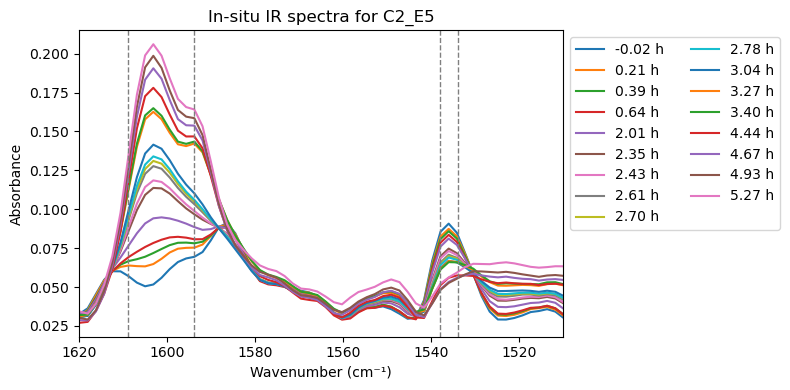

In [6]:
plot_ir_spectra(
    'ESI_SAKE_IR_spectra.xlsx', 
    stop_at=None, 
    selected=None, 
    x_limits=[1510, 1620], 
    y_limits='5%' ,
    y_shifter=0, 
    figsize=(8, 4), 
    legend=True, 
    save_svg=True,
    legend_outside=True,
    time_label='h',
    experiment_start=['09:08:16','10:49:45'],
    legend_limit=10,
    sheet='C2_E5',
    vertical_lines=[[1538,1534,1609,1594],[]],
    n_spectra=17,
    experiment_name='C2_E5'
)


__C2_E6__

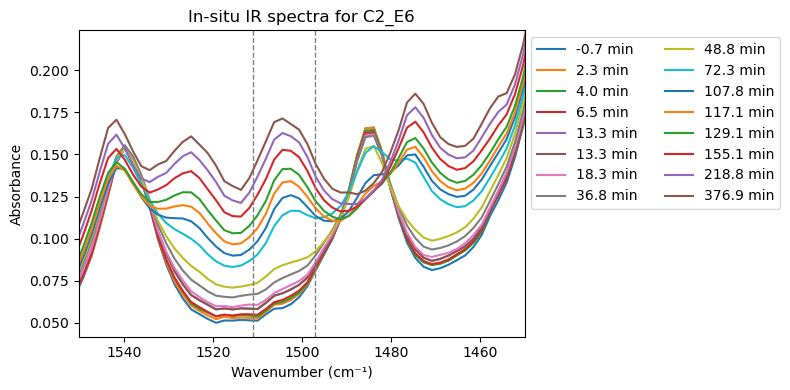

In [7]:
plot_ir_spectra(
    'ESI_SAKE_IR_spectra.xlsx', 
    stop_at=None, 
    selected=None, 
    x_limits=[1450, 1550], 
    y_limits='5%' ,
    y_shifter=0, 
    figsize=(8, 4), 
    legend=True, 
    save_svg=True,
    legend_outside=True,
    time_label='min',
    experiment_start=['08:08:46','08:25:24'],
    legend_limit=10,
    sheet='C2_E6',
    vertical_lines=[[1265,1249,1511,1497],[]],
    n_spectra=16,
    experiment_name='C2_E6'
)


__C2_E7b__

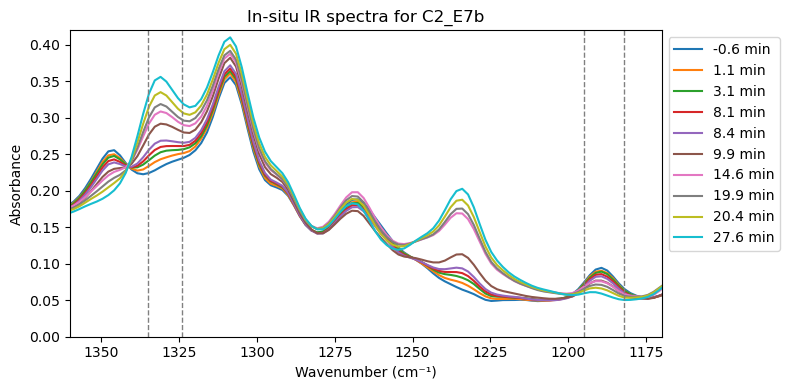

In [8]:
plot_ir_spectra(
    'ESI_SAKE_IR_spectra.xlsx', 
    stop_at=None, 
    selected=None, 
    x_limits=[1170, 1360], 
    y_limits=[00.0, 0.42], 
    y_shifter=0, 
    figsize=(8, 4), 
    legend=True, 
    save_svg=True,
    legend_outside=True,
    time_label='min',
    experiment_start=['16:06:25','16:23:12'],
    legend_limit=10,
    sheet='C2_E7b',
    vertical_lines=[[1195,1182,1335,1324],[]],
    n_spectra=10,
    experiment_name='C2_E7b'
)


__C3_E3__

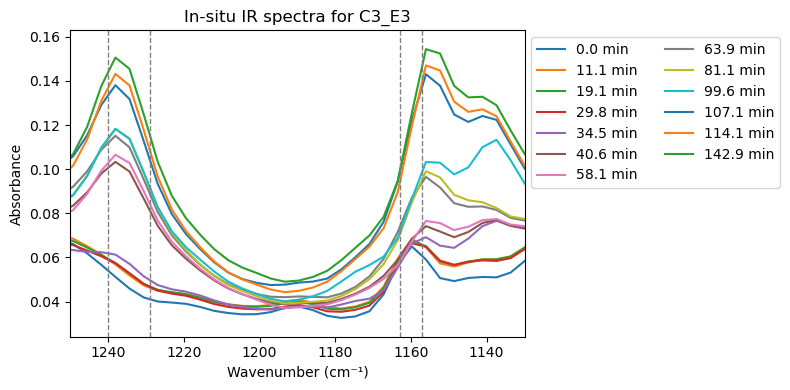

In [9]:
plot_ir_spectra(
    'ESI_SAKE_IR_spectra.xlsx', 
    stop_at=None, 
    selected=None, 
    x_limits=[1130, 1250], 
    y_limits='7%', 
    y_shifter=0, 
    figsize=(8, 4), 
    legend=True, 
    save_svg=True,
    legend_outside=True,
    time_label='min',
    experiment_start=['11:25:58','11:35:50'],
    legend_limit=10,
    sheet='C3_E3',
    vertical_lines=[[1163,1157,1240,1229],[]],
    n_spectra=13,
    experiment_name='C3_E3'
)


__C3_E4__

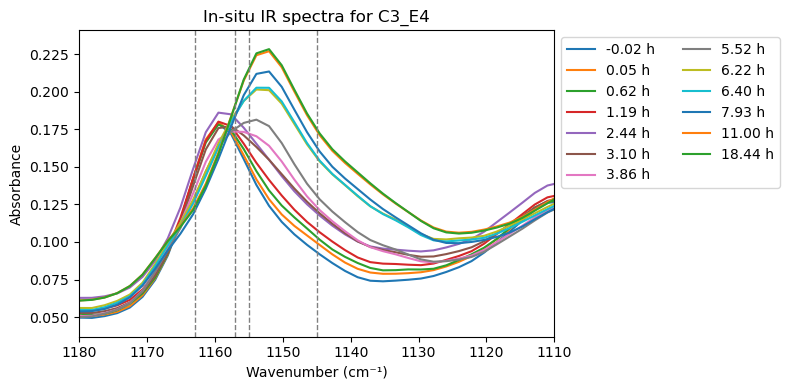

In [10]:
plot_ir_spectra(
    'ESI_SAKE_IR_spectra.xlsx', 
    stop_at=None, 
    selected=None, 
    x_limits=[1110, 1180], 
    y_limits='7%', 
    y_shifter=0, 
    figsize=(8, 4), 
    legend=True, 
    save_svg=True,
    legend_outside=True,
    time_label='h',
    experiment_start=['09:42:01','10:14:31'],
    legend_limit=10,
    sheet='C3_E4',
    vertical_lines=[[1163,1157,1155,1145],[]],
    n_spectra=13,
    experiment_name='C3_E4'
)


__C4_E3__

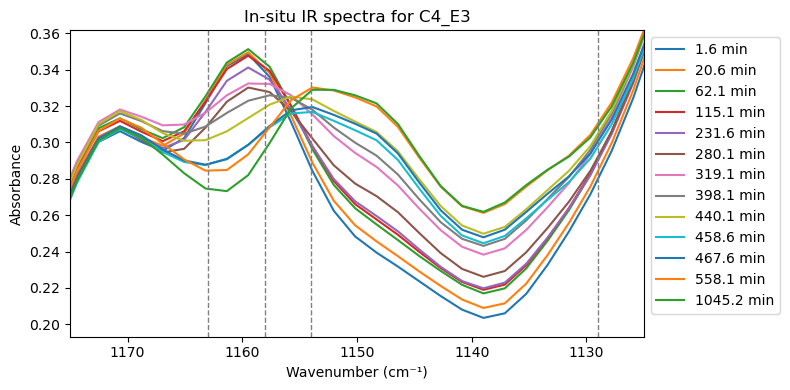

In [11]:
plot_ir_spectra(
    'ESI_SAKE_IR_spectra.xlsx', 
    stop_at=None, 
    selected=None, 
    x_limits=[1125, 1175], 
    y_limits='7%', 
    y_shifter=0, 
    figsize=(8, 4), 
    legend=True, 
    save_svg=True,
    legend_outside=True,
    time_label='min',
    experiment_start=['12:19:48','12:33:39'],
    legend_limit=20,
    sheet='C4_E3',
    vertical_lines=[[1163,1158,1154,1129],[]],
    n_spectra=13,
    experiment_name='C4_E3'
)


__C4_E11__

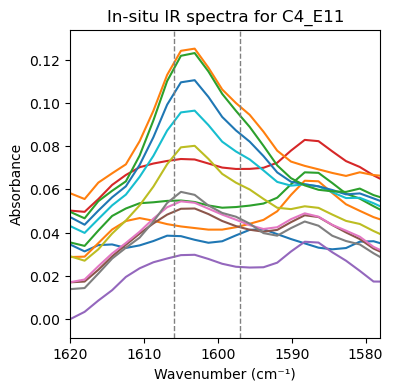

In [12]:
plot_ir_spectra(
    'ESI_SAKE_IR_spectra.xlsx', 
    stop_at=None, 
    selected=None, 
    x_limits=[1578, 1620], 
    y_limits='7%', 
    y_shifter=0, 
    figsize=(4, 4), 
    legend=False, 
    save_svg=True,
    legend_outside=True,
    time_label='min',
    experiment_start=['9:40:53','09:50:24'],
    legend_limit=15,
    sheet='C4_E11',
    vertical_lines=[[1163,1161,1606,1597],[]], 
    n_spectra=13,
    experiment_name='C4_E11'
)


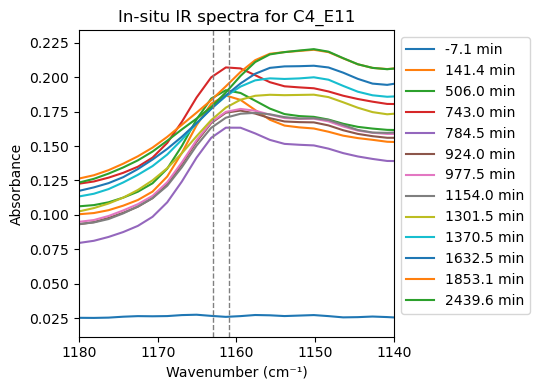

In [13]:
plot_ir_spectra(
    'ESI_SAKE_IR_spectra.xlsx', 
    stop_at=None, 
    selected=None, 
    x_limits=[1140, 1180], 
    y_limits='7%', 
    y_shifter=0, 
    figsize=(5.5, 4), 
    legend=True, 
    save_svg=True,
    legend_outside=True,
    time_label='min',
    experiment_start=['9:40:53','09:50:24'],
    legend_limit=20,
    sheet='C4_E11',
    vertical_lines=[[1163,1161,1606,1597],[]],
    n_spectra=13,
    experiment_name='C4_E11'
)
